## Introduction
This code and analysis was initially done Week 9 of the 2018 Fantasy Football Regular Season. I had a lot less experience in programming and thus did a lot of the work for the Markov Chain Monte Carlo (MCMC) manually, especially with finding and filling in values. Without suffering from over-automation, I re-created the same work to be more universally used.

This code takes the scores of each team thus far in the regular season, assumes the scores as normally distributed, and randomly generates a matchup to determine the next week's game. Each team only has 9 data points, so teams' scores hardly count as Gaussian. That being said, with the randomness of fantasy and the mantra of "Any Given Sunday", I thought the small sample size would be an advantage to emulate the volatile nature of fantasy scores. These matchups were simulated through 1000 times for the final 4 weeks: Weeks 10 through 13 to determine the most likely places of each team entering the playoffs. At the very end, I'll compare the actual final standings with the results of the chain and provide a heatmap to better visualize the results.


### Necessary Libraries
As always, we import the libraries necessary.

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

### Necessary Functions
We'll also run the functions necessary for the program at the top.

In [2]:
def team_win_loss(dataset, i):
    """
    Adding the win-loss record
    Input:  dataset: which dataset to use?
            i: iterator
    Output: wl_info: Series with the team identifier, win, loss, tie record, and total points
    """
    
    #specifying the team
    team = dataset[dataset["Team"] == team_ids[i]]
    
    #specifying wins, losses, ties
    team_wins = sum(n > 0 for n in team["Margin"])
    team_ties = sum(n == 0 for n in team["Margin"])
    team_loss = sum(n < 0 for n in team["Margin"])
    
    #total points
    points = np.sum(team.PointsFor)
    
    #outputting a Pandas Series of the necessary information
    wl_info = pd.DataFrame([[team_ids[i], team_wins, team_loss,
                             team_ties, points]],
                           columns = ["Team", "Wins", "Losses", "Ties", "Points"])
    return wl_info


def matchup(home_team, away_team, week):
    """
    Input:  home_team: home team number
            away_team: away team number
            week: which week for the matchup
    Output: extra_matchup 2-row DF. contains the results of the 1 vs. 1 matchup
            
    calculates who wins each individual matchup.
    assuming each team scores assumes a gaussian distribution
    """
    
    #getting the summaries for each team
    summary_stats = (pd.DataFrame([analysis.sort_values(by = ["Team"])
                                           .Team
                                           .unique(),
                                   analysis.groupby("Team")
                                           .mean()["PointsFor"],
                                   analysis.groupby("Team")
                                           .std()["PointsFor"]]).T)
    
    #cleaning the data set
    colnames = ["Team", "AvgPoints", "StDPoints"]
    summary_stats.columns = colnames
    
    #find each team's scores
    home = np.random.normal(summary_stats[summary_stats.Team == home_team].AvgPoints,
                            summary_stats[summary_stats.Team == away_team].StDPoints,
                            1) #only one score "Any given Sunday"
    away = np.random.normal(summary_stats[summary_stats.Team == home_team].AvgPoints,
                            summary_stats[summary_stats.Team == away_team].StDPoints,
                            1)
    
    #make same format as analysis data set
    home_row = np.array([week, home_team, home[0], (home - away)[0], away[0]])
    away_row = np.array([week, away_team, away[0], (away - home)[0], home[0]])
    
    #apped these rows to the analysis data set
    extra_matchup = (pd.DataFrame([home_row, away_row],
                                  columns = analysis.columns))
    
    return extra_matchup


"""
Dictionary to map team number to actual team name
"""
#team number to name Dictionary
mapping = {1: "Mount",
           2: "Alec",
           3: "Sirpi",
           4: "Oatman",
           5: "Babcock",
           9: "Jordan",
           11: "Casey",
           12: "Badillo",
           13: "Naki",
           14: "Kooper"}

### Accessing ESPN
Before we do any data manipulation, we have to access ESPN. We need the historical 2018 matchup data and since I'm going back to week 9 retroactively, we have to manually cut out everything from Week 10 and on.

In [3]:
league_id = 298982
year = 2018

url = "https://fantasy.espn.com/apis/v3/games/ffl/leagueHistory/" + str(league_id) + "?seasonId=" + str(year)
r = requests.get(url, params = {"view": "mMatchup"})
d = r.json()[0]

Since I've already played around with the JSON, I know the structure and what to access. Clicking through the <code>d</code> object reveals a lot about the league itself.

To move ahead, we'll create an intial source data set that contains each Week, the team in the matchup, and corresponding score. The first few lines are a precaution to remove any empty matchups, which is more pertinent for in-session leagues.

### Creating Analytical Data Set

In [4]:
maximum = max(pd.DataFrame(d["schedule"]).index.tolist()) #how many obs?
length_df = pd.DataFrame([[d["schedule"][i]["winner"]] for i in range(maximum)])
length_df = length_df[length_df[0] != "UNDECIDED"]
length = range(len(length_df))


#Selecting weeks, points, data
source = pd.DataFrame([[d["schedule"][i]["matchupPeriodId"],
                        d["schedule"][i]["home"]["teamId"],
                        d["schedule"][i]["home"]["totalPoints"],
                        d["schedule"][i]["away"]["teamId"],
                        d["schedule"][i]["away"]["totalPoints"]] for i in length],
                        columns = ["Week", "Team1", "Score1", "Team2", "Score2"])

source.head()

,Week,Team1,Score1,Team2,Score2
0,1,11,97.0,3,102.0
1,1,4,107.0,13,130.0
2,1,5,87.0,12,98.0
3,1,9,139.0,1,76.0
4,1,14,89.0,2,71.0


In [5]:
source.Week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

The above piece of code <code>source.Week.unique()</code> shows that this data contains information all the way up to week 15. The reason it stops at 15 is that this league has 2 rounds of 2-week playoffs. So, "Week 14" really is the congregated points of Week 14 and 15, and "Week 15" is the congregated points of Week 16 and 17. This <code>source</code> data set needs every week after 9 removed. We'll also add a column for each team's Margin of Victory/Defeat. This will come more in handy later down the road when we need to calculate wins and losses:

In [6]:
#add margin of defeat/victory
margins = source.assign(Margin1 = source["Score1"] - source["Score2"],
                        Margin2 = source["Score2"] - source["Score1"])

margins.head()

,Week,Team1,Score1,Team2,Score2,Margin1,Margin2
0,1,11,97.0,3,102.0,-5.0,5.0
1,1,4,107.0,13,130.0,-23.0,23.0
2,1,5,87.0,12,98.0,-11.0,11.0
3,1,9,139.0,1,76.0,63.0,-63.0
4,1,14,89.0,2,71.0,18.0,-18.0


In [7]:
#only first 9 weeks of data
source_9 = margins[margins.Week < 10]

source_9.Week.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

We successfully cut out all data after Week 9, meaning in this case, we've reverted back to Week 9 of the 2018 season.

Now that we have <code>source_9</code>, it should be transformed from wide to long, such that each week has an entry for each team. This will make the data set easier to read and manipulate:

In [8]:
#transform from wide to long
source_long = (source_9.loc[:, ("Week", "Team1", "Score1", "Margin1")]
                         .rename(columns = {"Team1": "Team",
                                            "Score1": "Score",
                                            "Margin1": "Margin"})
                         .append(source_9.loc[:, ("Week", "Team2", "Score2", "Margin2")]
                             .rename(columns = {"Team2": "Team",
                                                "Score2": "Score",
                                                "Margin2": "Margin"})))

source_long = (source_long.assign(PA = source_long.Score - source_long.Margin)
                          .rename(columns = {"Score": "PointsFor",
                                             "PA": "Points Against"}))

source_long.head()

,Week,Team,PointsFor,Margin,Points Against
0,1,11,97.0,-5.0,102.0
1,1,4,107.0,-23.0,130.0
2,1,5,87.0,-11.0,98.0
3,1,9,139.0,63.0,76.0
4,1,14,89.0,18.0,71.0


### Simulation

The entire simulation occurs within a loop. The algorithm is as follows:

1. Loop 1000 times (1000 simulations). This is the outermost loop.
2. The first inner loop is a nested loop. The outer loop goes through all the remaining weeks in the regular season (10 to 13) and divies up the source data by that week.
    1. The nested loop within this loop takes each matchup and runs the <code>matchup</code> function to find the winner of the game was simmed just once. The result is appended back into the source data to loop through with the new average points and standard deviation values.
3. The second inner loop takes the result of all the matchups and calculates the end of season win/loss record.
4. Finally, the final standings are saved into a list, <code>sim_standings</code>.

In [9]:
#simming 1000 times
sim_standings = pd.DataFrame()

for l in range(1000):

    #the data that will be used throughout
    analysis = source_long.copy()
    
    #Outer loop to create the weekly object
    for i in range(10, 14):
        weekly_matchups = margins[margins.Week == i].loc[:, ["Team1", "Team2"]]
        week = i
        
        #inner loop to do the matchup
        for j in range(5):
            home_team = weekly_matchups.iloc[j, 0]
            away_team = weekly_matchups.iloc[j, 1]
            
            #simming the winner of the matchup
            result = matchup(home_team, away_team, i)
            
            #adding the new points values to the source data
            analysis = analysis.append(result)
            
            
    #creating record from values
    team_ids = source_long.Team.unique()
    
    #initialize an empty dataframe to append to
    win_loss = []
    
    #loop through all the teams and have the rows append
    for j in range(len(team_ids)):
        row = team_win_loss(analysis, j)
        win_loss.append(row)
    
    win_loss = (pd.concat(win_loss)
                  .sort_values(by = ["Wins", "Ties", "Points"], ascending = False)
                  .assign(Standing = np.arange(1, 11))
                  .sort_values(by = ["Team"])
                  .reset_index(drop = True))
    
    #save the standings within the object
    sim_standings[l] = win_loss.Standing

In [10]:
sim_standings.shape

(10, 1000)

With 1000 run throughs, we inspect the shape instead of producing the first few rows in a <code>.head()</code>. The function <code>matchup</code> is self-explanatory: the 10 rows means one input for each team for each simulation. The 1000 columns are the 1000 results of the loop. To understand, here are the first few columns of the Data Frame:

In [11]:
sim_standings.iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
0,8,9,9,8,7,9,10,9,8,8
1,2,7,6,3,9,2,7,6,5,5
2,10,10,10,9,8,10,6,10,9,7
3,4,3,4,4,3,6,1,4,1,4
4,7,6,8,10,10,8,4,7,6,9
5,6,5,3,5,5,5,5,3,4,2
6,3,1,7,1,2,4,2,2,2,1
7,5,4,2,6,4,1,8,5,7,6
8,1,2,1,2,1,3,3,1,3,3
9,9,8,5,7,6,7,9,8,10,10


### Analyzing the Simulation

The resulting data set is nice, since we have all the simulations. We know each column comes from the <code>"Standings"</code> column in the <code>win_loss</code> Data Frame. Thus, we know the order of teams stays consistent throughout the output into the Data Frame. To make things clearer, we'll add the team number and name into the Data Frame:

In [12]:
sim_standings.insert(loc = 0, value = win_loss.Team, column = "Team")
sim_standings.iloc[:, 0:10]

,Team,0,1,2,3,4,5,6,7,8
0,1,8,9,9,8,7,9,10,9,8
1,2,2,7,6,3,9,2,7,6,5
2,3,10,10,10,9,8,10,6,10,9
3,4,4,3,4,4,3,6,1,4,1
4,5,7,6,8,10,10,8,4,7,6
5,9,6,5,3,5,5,5,5,3,4
6,11,3,1,7,1,2,4,2,2,2
7,12,5,4,2,6,4,1,8,5,7
8,13,1,2,1,2,1,3,3,1,3
9,14,9,8,5,7,6,7,9,8,10


Great! We have the team number right at the beginning of the Data Frame. The ultimate goal is to get a count of each "standing" for each team:

In [13]:
sim_standings.loc[9, :].value_counts()

8     274
7     207
9     182
10    127
6     113
5      67
4      27
3       3
14      1
Name: 9, dtype: int64

This gives a frequency table of all the standings Team 9 got through the simulation. We know its team 14 because I specified the <code>9</code> in <code>loc[9, :]</code> in the code above, and under the <code>Name</code> of the vector, its <code>9</code>. The issue is, the Team column is a numeric column, so it gets counted along in the frequency table. We would benefit from replacing the Team Numbers with Team Names and moving it to the index:

In [14]:
#adding team name, making it the index
final = sim_standings.replace({"Team": mapping}).set_index("Team")
final.iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
Team,,,,,,,,,,
Mount,8,9,9,8,7,9,10,9,8,8
Alec,2,7,6,3,9,2,7,6,5,5
Sirpi,10,10,10,9,8,10,6,10,9,7
Oatman,4,3,4,4,3,6,1,4,1,4
Babcock,7,6,8,10,10,8,4,7,6,9
Jordan,6,5,3,5,5,5,5,3,4,2
Casey,3,1,7,1,2,4,2,2,2,1
Badillo,5,4,2,6,4,1,8,5,7,6
Naki,1,2,1,2,1,3,3,1,3,3


Perfect. We have the team name as the index of the data frame and every single column is the index of the simulations. Now we can find the frequency table of each team, to see at what rate each team ended at which standing:

In [15]:
#how many at each rank?
final.loc["Mount", :].value_counts()
counts = pd.DataFrame([final.loc[i, :].value_counts() for i in mapping.values()])

#replace NA with 0
counts.fillna(0, inplace = True)

counts

,1,2,3,4,5,6,7,8,9,10
Mount,0.0,0.0,0.0,4.0,20.0,46.0,169.0,226.0,346.0,189.0
Alec,14.0,45.0,96.0,158.0,227.0,243.0,129.0,67.0,21.0,0.0
Sirpi,0.0,0.0,0.0,0.0,0.0,9.0,45.0,121.0,225.0,600.0
Oatman,170.0,230.0,287.0,161.0,84.0,52.0,15.0,1.0,0.0,0.0
Babcock,0.0,0.0,10.0,33.0,64.0,131.0,261.0,214.0,204.0,83.0
Jordan,24.0,85.0,152.0,253.0,221.0,146.0,76.0,30.0,13.0,0.0
Casey,278.0,297.0,172.0,135.0,71.0,42.0,5.0,0.0,0.0,0.0
Badillo,21.0,65.0,127.0,173.0,229.0,215.0,93.0,67.0,9.0,1.0
Naki,493.0,278.0,153.0,56.0,17.0,3.0,0.0,0.0,0.0,0.0
Kooper,0.0,0.0,3.0,27.0,67.0,113.0,207.0,274.0,182.0,127.0


Since this is 1000 simulations, all we have to do is divide the entire data frame by 10 to get the percentages:

In [16]:
counts/10

,1,2,3,4,5,6,7,8,9,10
Mount,0.0,0.0,0.0,0.4,2.0,4.6,16.9,22.6,34.6,18.9
Alec,1.4,4.5,9.6,15.8,22.7,24.3,12.9,6.7,2.1,0.0
Sirpi,0.0,0.0,0.0,0.0,0.0,0.9,4.5,12.1,22.5,60.0
Oatman,17.0,23.0,28.7,16.1,8.4,5.2,1.5,0.1,0.0,0.0
Babcock,0.0,0.0,1.0,3.3,6.4,13.1,26.1,21.4,20.4,8.3
Jordan,2.4,8.5,15.2,25.3,22.1,14.6,7.6,3.0,1.3,0.0
Casey,27.8,29.7,17.2,13.5,7.1,4.2,0.5,0.0,0.0,0.0
Badillo,2.1,6.5,12.7,17.3,22.9,21.5,9.3,6.7,0.9,0.1
Naki,49.3,27.8,15.3,5.6,1.7,0.3,0.0,0.0,0.0,0.0
Kooper,0.0,0.0,0.3,2.7,6.7,11.3,20.7,27.4,18.2,12.7


### Comparison
#### Predicted (Simulated) Standings

If we take the plurality of each standing, the simulations shows the final regular season standing as such:

Playoffs:
1. Naki
2. Casey
3. Oatman
4. Jordan

Sacko:
5. Badillo
6. Alec
7. Babcock
8. Kooper
9. Mount
10. Sirpi (60.0%!)

In [17]:
#where are the teams most likely to place based on the sim?
predicted_ranks = (pd.DataFrame([counts.max(), counts.idxmax()])
                        .T
                        .assign(Rank = np.arange(1, 11)))
colnames = ["Count", "Team", "Rank"]
predicted_ranks.columns = colnames
predicted_ranks = predicted_ranks.set_index("Team")
predicted_ranks

,Count,Rank
Team,,
Naki,493,1
Casey,297,2
Oatman,287,3
Jordan,253,4
Badillo,229,5
Alec,243,6
Babcock,261,7
Kooper,274,8
Mount,346,9


#### Observed Standings
This is a slight rehash of code used above. We will reproduce the win-loss Data Frame, but applied up to Week 13 (last week of fantasy regular season):

In [18]:
#Observed ranks
#transform from wide to long
source_13 = margins[margins.Week <= 13]
margins_long = (source_13.loc[:, ("Week", "Team1", "Score1", "Margin1")]
                         .rename(columns = {"Team1": "Team",
                                            "Score1": "PointsFor",
                                            "Margin1": "Margin"})
                         .append(source_13.loc[:, ("Week", "Team2", "Score2", "Margin2")]
                             .rename(columns = {"Team2": "Team",
                                                "Score2": "PointsFor",
                                                "Margin2": "Margin"})))

#initialize an empty dataframe to append to
final_win_loss = []

#loop through all the teams and have the rows append
for j in range(len(team_ids)):
    row = team_win_loss(margins_long, j)
    final_win_loss.append(row)

final_win_loss = (pd.concat(final_win_loss)
                    .sort_values(by = ["Wins", "Ties", "Points"], ascending = False)
                    .assign(Standing = np.arange(1, 11))
                    .sort_values(by = ["Team"])
                    .reset_index(drop = True))

final_win_loss

,Team,Wins,Losses,Ties,Points,Standing
0,1,4,8,1,1121.0,10
1,2,8,5,0,1239.0,3
2,3,6,7,0,1189.0,6
3,4,8,5,0,1309.0,2
4,5,5,7,1,1372.0,7
5,9,6,6,1,1316.0,5
6,11,6,6,1,1401.0,4
7,12,5,7,1,1218.0,8
8,13,10,3,0,1364.0,1
9,14,4,8,1,1243.0,9


We will now select the <code>Standing</code> and <code>Team</code> from each Data Frame and mash them together for a side-by-side comparison:

In [23]:
comparison = (final_win_loss.replace({"Team": mapping})
                            .set_index("Team")
                            .merge(how = "right",
                                   right = predicted_ranks,
                                   left_index = True,
                                   right_index = True)
                            .loc[:, ["Rank", "Standing"]]
                            .rename(columns = {"Rank": "Predicted",
                                               "Standing": "Observed"}))
comparison

,Predicted,Observed
Team,,
Naki,1,1
Casey,2,4
Oatman,3,2
Jordan,4,5
Badillo,5,8
Alec,6,3
Babcock,7,7
Kooper,8,9
Mount,9,10


Both columns are ordered ranks, and thus a Kendall's Tau test is appropriate to test for association. The following hypotheses apply for a Kendall's Tau test:

$H_{0}$: Absence of association between the 2 columns.<br>
$H_{A}$: Association between the 2 columns.

Kendall's Tau test comes from the <code>scipy.stats</code> package. The order of arguments for the <code>kendalltau</code> function doesn't matter; $\tau$ will stay consistent.

In [24]:
tau, p_value = stats.kendalltau(comparison.Predicted, comparison.Observed)
print(tau, p_value)

0.6 0.016666115520282188


The resulting p-value of 0.017 is less than the usual 0.05 and thus we reject the null hypothesis. We instead assume the alternative hypothesis: there is indeed an association between the 2 columns. The $\tau$ value of 0.6 depicts a relatively strong association between the 2.

That being said, the simulation leaves Jordan out of the playoffs and isntead Alec slides in. As always, the law of large numbers speaks towards trends - the highest average score will more likely be a higher seed. Whereas in fantasy, "any given Sunday" and randomness leads to the differences between a large simulation and what actually happened in the league.

What is extremely surprising is Sirpi had a 0.9% chance of accomplishing the 6 seed. 9 out of 1000 tries and in the league, that result was actually observed. I guess even the smallest chance means a chance.

https://tenor.com/view/dumb-and-dumber-lloyd-theres-achance-gif-11098164

### Heatmap

This data set is prime for a heatmap, with different percentages for different standings. We'll create a heatmap, red to green, of where each team will most probably end up.

In [21]:
#reorder the dataset from highest seed to lowest seed, divide by 10 for percentages
counts2 = counts.reindex(predicted_ranks.index) / 10

#define a red to green color map
cmap = sns.diverging_palette(10, 150, as_cmap = True)

counts2

,1,2,3,4,5,6,7,8,9,10
Team,,,,,,,,,,
Naki,49.3,27.8,15.3,5.6,1.7,0.3,0.0,0.0,0.0,0.0
Casey,27.8,29.7,17.2,13.5,7.1,4.2,0.5,0.0,0.0,0.0
Oatman,17.0,23.0,28.7,16.1,8.4,5.2,1.5,0.1,0.0,0.0
Jordan,2.4,8.5,15.2,25.3,22.1,14.6,7.6,3.0,1.3,0.0
Badillo,2.1,6.5,12.7,17.3,22.9,21.5,9.3,6.7,0.9,0.1
Alec,1.4,4.5,9.6,15.8,22.7,24.3,12.9,6.7,2.1,0.0
Babcock,0.0,0.0,1.0,3.3,6.4,13.1,26.1,21.4,20.4,8.3
Kooper,0.0,0.0,0.3,2.7,6.7,11.3,20.7,27.4,18.2,12.7
Mount,0.0,0.0,0.0,0.4,2.0,4.6,16.9,22.6,34.6,18.9


Text(0.5, 1.0, '1000 Simulations - Percentage of Each Final Standing')

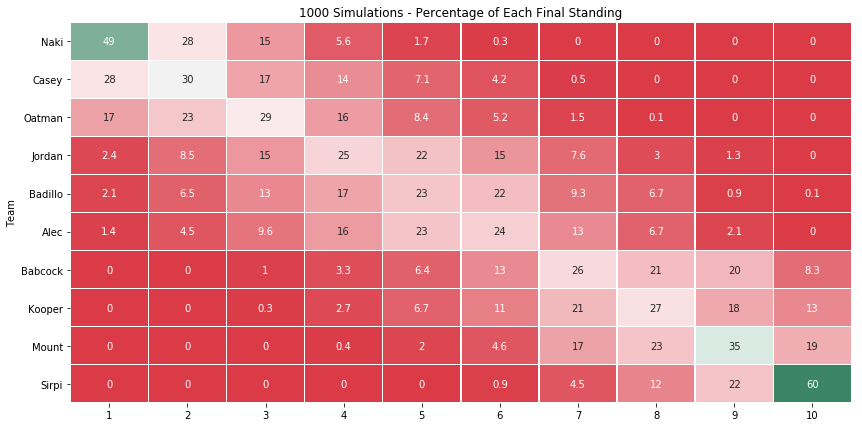

In [22]:
#output the image
plt.figure(figsize = (14, 7))
sns.heatmap(counts2, cmap = cmap, cbar = False,
            annot = counts2, linewidth = 0.5)
plt.title("1000 Simulations - Percentage of Each Final Standing")